In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# try:
#   tf.config.experimental.set_memory_growth(physical_devices[0], True)
# except:
#   # Invalid device or cannot modify virtual devices once initialized.
#   pass

load_dotenv(override=True)

DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)

# Choose subontology (CCO, MFO or BPO)
SO = 'BPO'

2023-07-02 18:09:11.749474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 18:09:12.494500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/cafa-5-protein-function-prediction


2023-07-02 18:09:14.005575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-02 18:09:14.095112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-02 18:09:14.095423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Reading fasta, obo and tsv files

In [2]:
from Bio import SeqIO

sequences = [rec.seq for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]
ids = [rec.id for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]

In [3]:
import networkx
import obonet

# Read the taxrank ontology
url = os.path.join(DATA_PATH, "Train/go-basic.obo")
graph = obonet.read_obo(url)



In [155]:
df = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfSO = df.loc[df["aspect"]==SO]
uniqueTerms = dfSO["term"].unique()
termsArr = list(dfSO["term"].to_numpy())

uniqueTermsDict={}
for i,el in enumerate(uniqueTerms):
    uniqueTermsDict[el] = i
    
print(dfSO.shape)
df=dfSO

df.set_index("EntryID", inplace=True)

(3497732, 3)


In [5]:
testID = df.index.to_list()[0]

## GO analysis

In [6]:
item_counts = df["term"].value_counts()

In [7]:
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

## Label encoding

The task is a multilabel classification: The output has several possible targets (Gene Ontologies) but each can only be 1 (existing) or 0 (non existing)

Extract label weights from IA

In [8]:
dfIa = pd.read_csv(os.path.join(DATA_PATH, "IA.txt"), sep='\t', header=None)

dfIa.set_index(0, inplace=True)

labelWeights=[]
allIndices = dfIa.index.tolist()



notFound=0
for go in item_counts.index.to_list():
    if go in allIndices:
        labelWeights.append(dfIa.loc[go].to_numpy()[0])
    else:
        notFound += 1
        labelWeights.append(0)

print("Not found GOs: {} (set to 0)".format(notFound))

Not found GOs: 0 (set to 0)


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

topGOs= item_counts
topGOs=topGOs.index.to_list()

#Reduce possible GOs by label weight
threshold=0
labelWeights=np.array(labelWeights)
selection = labelWeights>threshold
topGOs=np.array(topGOs)[selection]
labelWeights=labelWeights[selection]

mlb = MultiLabelBinarizer()
mlb.fit([topGOs])

dftest=df.loc[testID]
indices = dftest["term"].to_numpy()
print(indices)
print(mlb.transform([indices]))
print(len(mlb.classes_))

with open(os.path.join(DATA_PATH,'MLB_'+SO+'.pkl'), 'wb') as f:
    pickle.dump(mlb, f)

['GO:0008152' 'GO:0034655' 'GO:0072523' 'GO:0044270' 'GO:0006753'
 'GO:1901292' 'GO:0044237' 'GO:1901360' 'GO:0008150' 'GO:1901564'
 'GO:1901565' 'GO:0009117' 'GO:0006139' 'GO:0044281' 'GO:0046496'
 'GO:0019362' 'GO:0046483' 'GO:0055086' 'GO:0044248' 'GO:0019439'
 'GO:0019637' 'GO:0006807' 'GO:0019677' 'GO:1901361' 'GO:0006163'
 'GO:0046700' 'GO:0009987' 'GO:0006725' 'GO:0006796' 'GO:0034641'
 'GO:0072521' 'GO:0071704' 'GO:0019364' 'GO:1901575' 'GO:0072526'
 'GO:0046434' 'GO:0009166' 'GO:0072524' 'GO:0006195' 'GO:0009056'
 'GO:0044238' 'GO:0006793' 'GO:0019674']
[[0 0 0 ... 0 0 0]]
14109


/home/manuel/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['GO:0006195', 'GO:0008150', 'GO:0019364', 'GO:1901292'] will be ignored
  warnings.warn(


## Amino acids encoding

In [10]:
aa_dict = {'A': 1, 'B':24, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 21, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 22, 'V': 18, 'W': 19, 'Y': 20, 'X':30, 'Z':23}

## Build Dataset

In [11]:
seqLengths = [len(seq) for seq in sequences]
maxLen = max(seqLengths)
print("The max. length of the sequences is {}".format(maxLen))

The max. length of the sequences is 35375


In [12]:

dfAll=pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

soEntries = dfAll.loc[dfAll["aspect"]==SO]
soEntryIds = soEntries["EntryID"].unique()

# print(len(seqEntries))
print(soEntryIds)

# SoSequences = []
# for entry in soEntryIds:
#     SoSequences.append(sequences[ids.index(entry)])

# print(len(SoSequences))
dfAll.set_index("EntryID", inplace=True)

['A0A009IHW8' 'A0A021WW32' 'A0A023FFD0' ... 'X5L1L5' 'X5L565' 'X5M5N0']


In [13]:
import warnings
from itertools import product
from tqdm import tqdm
import os

TRAIN_VAL_SPLIT = 0.7
k = 3

allAA = list(aa_dict.keys())
allAA.sort()
allCombinations= list(product(*(allAA for i in range(k))))
allCombinations=np.array([''.join(el) for el in allCombinations])

positionDict = dict(zip(allCombinations, np.arange(0,allCombinations.size).T))

#Use numpy vectorize to speed up the mapping (hopefully)
mapping = lambda x: aa_dict[x]
vectMapping = np.vectorize(mapping)

# Shuffle the data
import random
random.seed(516213)
c = list(zip(sequences, ids))
random.shuffle(c)
sequencesShuffle, idsShuffle = zip(*c)


#Train Validation Split
split = int(np.floor(len(sequencesShuffle)*TRAIN_VAL_SPLIT))
print(split)
trainSeq = sequencesShuffle[0:split]
valSeq = sequencesShuffle[split+1:]
trainIds = idsShuffle[0:split]
valIds = idsShuffle[split+1:]


def generator():
  for i,seq in enumerate(trainSeq):
      entryId = trainIds[i]
      if entryId in soEntryIds:
        labelData = df.loc[entryId]
        # indices = labelData["termToken"].to_numpy()
        indices = labelData["term"].to_numpy()
      else: 
        indices=[]

      with warnings.catch_warnings():
          #supress the warnings for unknown classes
          warnings.simplefilter("ignore")
          y = mlb.transform([indices])

      # if np.count_nonzero(y)==0 and np.random.random()>nonRelevantThreshold:
      #   continue

      
      kmers = [seq[j:j+k] if j < len(seq)-(k-1) else 0 for j,el in enumerate(seq)]
      kmers = kmers[0:-(k-1)]
      kmers = [str(el) for el in kmers]
      values, counts = np.unique(kmers, return_counts=True)
      freqVector=np.zeros(allCombinations.shape)
      for l,v in enumerate(values):
          freqVector[positionDict[v]] = counts[l]
      yield (freqVector,y[0])


def generatorVal():
  for i,seq in enumerate(valSeq):
      entryId = valIds[i]
      if entryId in soEntryIds:
        labelData = df.loc[entryId]
        # indices = labelData["termToken"].to_numpy()
        indices = labelData["term"].to_numpy()
      else:
        indices=[]

      with warnings.catch_warnings():
          #supress the warnings for unknown classes
          warnings.simplefilter("ignore")
          y = mlb.transform([indices])

      # if np.count_nonzero(y)==0 and np.random.random()>nonRelevantThreshold:
      #   continue
      
      kmers = [seq[j:j+k] if j < len(seq)-(k-1) else 0 for j,el in enumerate(seq)]
      kmers = kmers[0:-(k-1)]
      kmers = [str(el) for el in kmers]
      values, counts = np.unique(kmers, return_counts=True)
      freqVector=np.zeros(allCombinations.shape)
      for l,v in enumerate(values):
          freqVector[positionDict[v]] = counts[l]
      yield (freqVector,y[0])
        

99572


In [14]:
g = generator()
test = next(g)
print("The first sample: \n{}\n{}".format(test[0].shape, test[0][0:100]))
print("The first sample has {} classes".format(np.count_nonzero(test[1])))

The first sample: 
(15625,)
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0.]
The first sample has 0 classes


## One-vs-Rest Classification

In [204]:
target = mlb.classes_[671]

def getKmers(seq):
    kmers = [seq[j:j+k] if j < len(seq)-(k-1) else 0 for j,el in enumerate(seq)]
    kmers = kmers[0:-(k-1)]
    kmers = [str(el) for el in kmers]
    values, counts = np.unique(kmers, return_counts=True)
    freqVector=np.zeros(allCombinations.shape)
    for l,v in enumerate(values):
        freqVector[positionDict[v]] = counts[l]
    return freqVector


X=[]
y=[]
positiveClassCount=0

for i,seq in enumerate(tqdm(trainSeq)):
    entryId = trainIds[i]
    if entryId in soEntryIds:
        labelData = df.loc[entryId]
        indices = labelData["term"].to_numpy()
    else: 
        indices=[]
    if target in indices:
        freqVector= getKmers(seq)
        X.append(freqVector)
        y.append(1)
        positiveClassCount += 1
    elif 0.2*len(y) < positiveClassCount:
        freqVector= getKmers(seq)
        X.append(freqVector)
        y.append(0)
    else:
        continue

X=np.array(X)
y=np.array(y)

    

100%|██████████| 99572/99572 [01:35<00:00, 1045.81it/s]


In [205]:

Xval=[]
yval=[]
positiveClassCountVal=0
for i,seq in enumerate(tqdm(valSeq)):
    entryId = valIds[i]
    if entryId in soEntryIds:
        labelData = df.loc[entryId]
        indices = labelData["term"].to_numpy()
    else: 
        indices=[]
    if target in indices:
        freqVector= getKmers(seq)
        Xval.append(freqVector)
        yval.append(1)
        positiveClassCountVal += 1
    elif len(yval)/2 < positiveClassCountVal:
        freqVector= getKmers(seq)
        Xval.append(freqVector)
        yval.append(0)
    else:
        continue

Xval=np.array(Xval)
yval=np.array(yval)

  0%|          | 0/42673 [00:00<?, ?it/s]

100%|██████████| 42673/42673 [00:40<00:00, 1052.41it/s]


In [206]:
print(X.shape)
print(y.shape)
print(np.count_nonzero(y))
print(Xval.shape)
print(yval.shape)
print(np.count_nonzero(yval))

(1365, 15625)
(1365,)
273
(200, 15625)
(200,)
100


In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

# clf = LogisticRegression().fit(X, y)
# clf = svm.SVC(probability=True).fit(X, y)
# clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(4, 64)).fit(X, y)
clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(solver="liblinear"))
clf.fit(X, y)
print(clf.predict(Xval))
# print(clf.predict_proba(Xval))
print(clf.score(Xval, yval))

[1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1
 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0
 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1
 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1
 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1
 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0]
0.78


/home/manuel/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [124]:
def f1Score(yTrue, yPred):
    tp = np.count_nonzero(np.logical_and(np.array(yTrue, dtype="bool") , np.array(yPred, dtype="bool")))
    fn = np.count_nonzero(np.logical_and(np.logical_not(yTrue) , np.array(yPred, dtype="bool")))
    fp = np.count_nonzero(np.logical_and(np.array(yTrue, dtype="bool") , np.logical_not(yPred)))
    prec = (tp)/(tp+fp+1e-20)
    rec = tp/(tp+fn+1e-20)
    f1 = 2*(prec*rec)/(prec+rec+1e-20)
    return prec, rec, f1

In [146]:
f1Score(yval, clf.predict(Xval))

(0.5619047619047619, 0.921875, 0.6982248520710059)

----

In [156]:
dfGo = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfGo = dfGo.loc[dfGo["aspect"]==SO]
uniqueTerms = dfGo["term"].unique()
termsArr = list(dfGo["term"].to_numpy())

uniqueTermsDict={}
for i,el in enumerate(uniqueTerms):
    uniqueTermsDict[el] = i
    
print(dfGo.shape)

dfGo.set_index("term", inplace=True)

(3497732, 3)


In [198]:
seqDict = dict(zip(ids, sequences))
classifiers = []
scores=[]
f1Scores=[]

for l in tqdm(mlb.classes_):
    X=[]
    y=[]
    if dfGo.loc[l].size<3:
        classifiers.append(None)
        f1Scores.append(0)
        scores.append(0)
        continue

    relevantSequenceIds = dfGo.loc[l]["EntryID"].unique()
    for seqId in relevantSequenceIds:
        seq = seqDict[seqId]
        X.append(getKmers(seq))
        y.append(1)

    nonRelSeqIds = dfGo.sample(n=len(X))["EntryID"].unique()
    for seqId in nonRelSeqIds:
        if seqId in relevantSequenceIds:
            continue
        seq = seqDict[seqId]
        X.append(getKmers(seq))
        y.append(0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    try:
        clf = LogisticRegression().fit(X_train, y_train)
    except:
        classifiers.append(None)
        f1Scores.append(0)
        scores.append(0)
    classifiers.append(clf)
    f1Scores.append(f1Score(y_test, clf.predict(X_test)))
    # print(clf.predict_proba(Xval))
    scores.append(clf.score(X_test, y_test))



  0%|          | 1/14109 [00:00<1:46:01,  2.22it/s]/home/manuel/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  0%|          | 27/14109 [00:37<1:09:03,  3.40it/s]/home/manuel/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the 

KeyboardInterrupt: 

(array([1167.,   81.,  271.,  386.,  362., 2012., 2469., 2190., 1114.,
         505.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

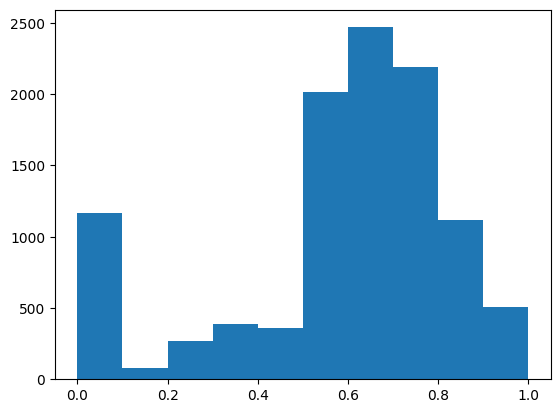

In [199]:
import matplotlib.pyplot as plt
plt.hist(scores)